In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

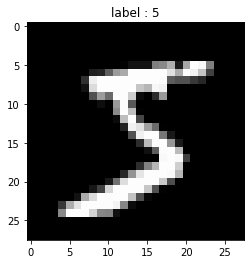

1.0
0.0
(60000,)
(60000, 10)
float64
(48000, 784)
(12000, 784)
(48000,)
(12000,)
(48000, 10)
(12000, 10)


In [3]:
# MNISTデータをmodel入力用に整形
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])
# 1次元にする
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 一つ可視化
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

# scaleを0 ~ 255から0 ~ 1にする
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

# OHE作成
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

# トレーニングとテストデータに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape) # (12000, 784)
print(y_val.shape) # (12000, 784)

# 分割後のyにOHE適用
y_train = enc.transform(y_train[:, np.newaxis])
y_val = enc.transform(y_val[:, np.newaxis])
print(np.shape(y_train))
print(np.shape(y_val))

In [ ]:
# ミニバッチ
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]


In [ ]:
# 結果確認、分析用の関数
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# scoreまとめ表示
def eval_accuracy(model, X_test, y_test, model_name):
    pred_y = snn_tanh.predict(X_test)
    nn_result = pd.DataFrame(
        [accuracy_score(y_test, pred_y), precision_score(y_test, pred_y, average='micro'), recall_score(y_test, pred_y, average='micro')],
        index=['Accuracy', 'Precision', 'Recall'],
        columns=[model_name]
    )
    return nn_result

# 損失値の推移
def display_loss_graph(model):
    iter_list = list(range(len(model.loss_train)))
    plt.scatter(iter_list, model.loss_train, label="train loss")
    plt.scatter(iter_list, model.loss_val, label="test loss")
    plt.ylabel('loss')
    plt.xlabel('iter')
    plt.legend()
    plt.show()

In [ ]:
class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, batch_size = 20, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, sigma = 0.02 ,lr = 0.01, epoch = 10, verbose=True):
        self.verbose = verbose
        # 一度に学習させるデータの数
        self.batch_size = batch_size
        # 説明変数の特徴量数
        self.n_features = n_features
        # 1層目のnode数
        self.n_nodes1 = n_nodes1
        # 2層目のnode数
        self.n_nodes2 = n_nodes2 
        # 出力層のnode数
        self.n_output = n_output
        # 正規分布の平均値
        self.sigma = sigma
        # 学習率
        self.lr = lr
        # 学習回数
        self.epoch = epoch
        self.loss_train = []
        self.loss_val = []
        
        # 標準正規分布（ガウス分布）のランダムな値を(n_features, n_nodes1)とり、入力のfeatureそれぞれに重みがつきそれがnode分ある。
        # nodeにはbatch_size分のデータが入ってくるので、nodeの出力は(batch_size, n_nodes1)となる
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        # 上同様のでnode1, node2の間の重みの初期値
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        # 上同様のでnode2, 出力の間の重みの初期値
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        # バイアス、n_nodes1分, バイアスもnode毎にある。これもガウス分布よりランダム値生成
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)
   
    def fit(self, X, y, X_val=None, y_val=None):
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数

        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()


        for _ in range(self.epoch):
            # 全データを使わず一部のデータを使って重みを算出する
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                # 各層のA, Zを計算
                self.forward(mini_X_train)
                # 各W, Bを更新
                self.backward(mini_X_train, mini_y_train)
            # 学習後、全データでA,Z計算
            self.forward(X)
            # 損失計算
            self.loss_train.append(self.cross_entropy_error(y, self.Z3))
            if X_val is not None:
                self.forward(X_val)
                self.loss_val.append(self.cross_entropy_error(y_val, self.Z3))
        if self.verbose:
            if X_val is None:
                print(self.loss_train)
            else:
                print(self.loss_train,self.loss_val)

    # フォワードプロパゲーション
    def forward(self, X):
        
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)


        self.A1 = X @ self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self.tanh_function(self.A2)
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)
    
    # バックプロパゲーション
    def backward(self, X, y):
        dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
        
        
        # 3層目
        dA3 = (self.Z3 - y)/self.batch_size
        dW3 = self.Z2.T @ dA3
        dB3 = np.sum(dA3, axis=0)
        dZ2 = dA3 @ self.W3.T
        # 2層目
        dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
        dW2 = self.Z1.T @ dA2
        dB2 = np.sum(dA2, axis=0)
        dZ1 = dA2 @ self.W2.T
        # 1層目
        dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
        dW1 = X.T @ dA1
        dB1 = np.sum(dA1, axis=0)
        # 各勾配より勾配降下法で正解に近づけていく。
        self.W3 -= self.lr * dW3
        self.B3 -= self.lr * dB3
        self.W2 -= self.lr * dW2
        self.B2 -= self.lr * dB2
        self.W1 -= self.lr * dW1
        self.B1 -= self.lr * dB1
            
    # 活性化関数(tanh: ハイパボリックタンジェント)
    def tanh_function(self, X):
        result = (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
        # or
        #  result = np.tanh(X)
        return result

    # 活性化関数(softmax)
    def softmax(self, X):
        result = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
        return result

    # 損失関数
    def cross_entropy_error(self, y, Z):
        L = - np.sum(y * np.log(Z+1e-7)) / len(y)
        return L
        
    def predict(self, X):
        self.forward(X)
        return np.argmax(self.Z3, axis=1)
    
    # 恒等関数
    def identity_function(self,X):
        return X

    # ステップ関数 0
    def step_function(self,X):
        result = np.array(X >= 0, dtype=np.int)
        return result
    
    # relu関数（レルー） 0以上
    def relu(self,X):
        result = np.max([np.zeros(X.shape), X], axis=0)   
        return result
    
    # シグモイド関数
    def sigmoid(self,X):
        result = 1 / (1 + np.exp(-X))   
        return result

